In [1]:
import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import sys

In [16]:
class VolData:
    def __init__(self, ticker, save_csv=False):
        self.ticker = ticker
        self.save_csv = save_csv
        p = yf.Ticker(self.ticker).info
        self.mid_price = (p['ask'] + p['bid'])/2
        
        """
        Initializing Class.
        Parameters
        ----------
        ticker: string 
            The stock ticker of interest        
        save_csv: boolean
            Select 'True' to save all of the option data in a csv file
        mid_price: integer
            Retrieves the mid-price of the stock which will be used in the class methods
        
        Example
        ---------
        >>> import yahoo_vol as yvol
        >>> data = yvol.Options(ticker="AAPL", n=3, save_csv=False)
        """
        
    def get_input_data(self):
        """
        Intermediate function used to collect the pricing data for plotting purposes. 
        Parameter:
        ------------
        save_csv: boolean
            Select True to save the options data to a csv file
            
        Returns
        -------------
        dataframe:
            A dataframe with corresponding statistics for each option
        csv:
            A csv file will be saved if save_csv is set to True
            
        Example
        -------------
        >>> df = data.get_input_data(save_csv=True)
        """
        storage = []
        x = yf.Ticker(self.ticker)
        option_dates = x.options
        if len(option_dates) == 0:
            sys.exit("Ticker does not have any options. Please try another ticker")
        for date in tqdm(option_dates):
            try:
                call, put = x.option_chain(date)[0], x.option_chain(date)[1]
                call['option_type'], put['option_type'] = ('call', 'put')
                call['maturity'], put['maturity'] = (date, date)
                d = pd.concat([call, put])
                storage.append(d)
            except:
                print(date, "option maturity failed to download")
                pass
        print("All option dates successfully downloaded: ", len(storage) == len(option_dates))
        df = pd.concat(storage)
        df = df.reset_index()    
        #df['maturity'] = pd.DataFrame([i[-15:-9] for i in df.contractSymbol])
        if self.save_csv==True:
            df.to_csv(str(ticker)+"_option_data.csv")
        return df

    def plot_vol_smile(self):
        """
        Plots the raw implied volatility against the respective strike values for all option 
        maturities.
            
        Returns
        -------------
        plt.plot figure:
            Plots for each option maturity
        Example
        -------------
        >>> data.plot_vol_smile()
        """
        data = self.get_input_data()
        # Extract and sort unique option maturities
        maturities = list(set(data.maturity))
        maturities.sort()
        # Loop through each maturity and plot the respective volatility smile 
        for date in maturities:
            call = data[(data.maturity == date) & (data.option_type == 'call')]
            put = data[(data.maturity == date) & (data.option_type == 'put')]
            #$#title_date = datetime.date(2000 + int(date[:2]), 
            #                           int(date[2:4]), int(date[4:])).strftime("%B %d, %Y")
            plt.scatter(call.strike, call.impliedVolatility*100, c='g', label='Call Smile', alpha=0.50)
            plt.scatter(put.strike, put.impliedVolatility*100, c='r', label='Put Smile', alpha=0.50)
            plt.axvline(self.mid_price, linestyle='dashed', c='b', alpha=0.30, label='Mid Price (ATM)')
            plt.title(self.ticker.upper() + " Volatility Smile: " + date)
            plt.ylabel("Implied Volatility (%)")
            plt.xlabel("Strike")
            plt.legend()
            plt.show()

    def plot_vol_term_structure(self, n=3):
        
        """
        Plots the at-the-money (ATM) implied volatility for each respective option maturity to form
        a term structure plot.
            
        Parameter
        -------------
        n: integer
            "n" represents number of options above and below at-the-money (ATM) used to calculate the 
             volatility term structure. For example, assuming $1 strike differences, if n=3 and ATM Price=100, 
             then the following 7 strikes will be used for calculating the implied volatility term structure:
                 - Lower ATM: 97, 98, 99
                 - ATM: 100
                 - Upper ATM: 101, 102, 103
        Returns
        -------------
        plt.plot figure:
            Plot of implied volatility term structure
        Example
        -------------
        >>> data.plot_term_structure(n=3)
        """
        data = self.get_input_data()
        strikes = list(set(data.strike))
        maturities = list(set(data.maturity))
        
        # Find the closest 'n' strikes to the current mid-price to approximate ATM option volatility
        get_closest_strike = min(range(len(strikes)), key=lambda i: abs(strikes[i]- self.mid_price))
        closest_ATM_indexes = list(range(get_closest_strike - (n-1),
                                         get_closest_strike + n))
        closest_ATM_strikes = [strikes[i] for i in closest_ATM_indexes]
        
        # Loop through all maturities to calculate the average implied volatility for each point
        storage = []
        for date in maturities:
            try: 
                temp = data[(data.maturity == date)]
                storage.append(temp[temp['strike'].isin(closest_ATM_strikes)].impliedVolatility.mean())
            except:
                pass
        
        df = pd.DataFrame([maturities, storage]).T
        df = df.sort_values(0)
        df = df.dropna()
        
        # Plotting Code 
        plt.figure(figsize=(10,5)) 
        plt.plot(df[0], df[1]*100, marker='o')
        plt.gcf().autofmt_xdate()
        plt.xlabel("Date")
        plt.ylabel("Implied Volatility (%)")
        plt.title(str(self.ticker).upper() + " Volatility Term Structure")
        plt.tight_layout()
        plt.grid(True)
        plt.show()

In [17]:
x = VolData("spy")

 32%|███▏      | 12/37 [00:02<00:05,  4.50it/s]

2020-06-23 option maturity failed to download


100%|██████████| 37/37 [00:10<00:00,  3.57it/s]

All option dates successfully downloaded:  False


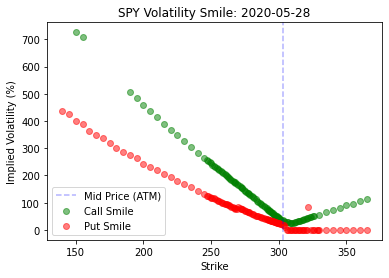

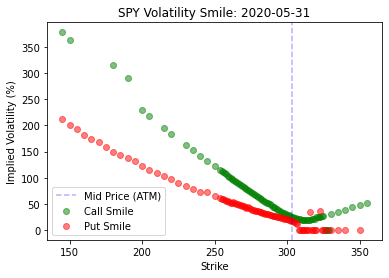

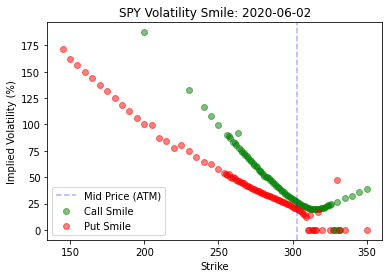

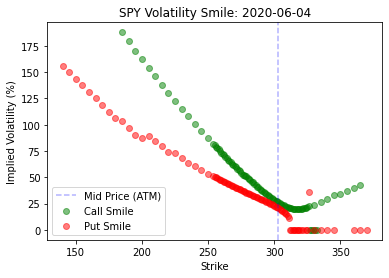

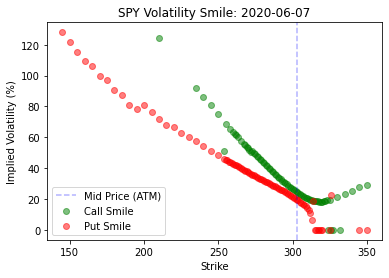

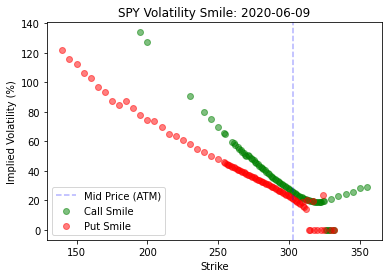

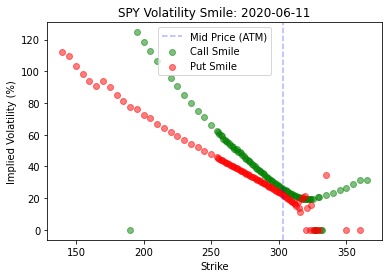

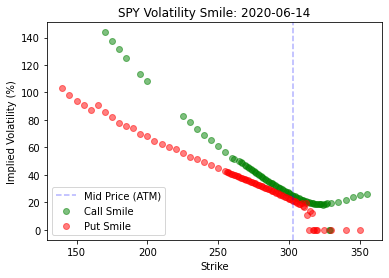

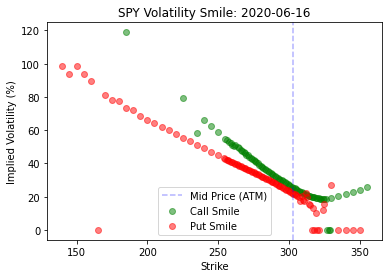

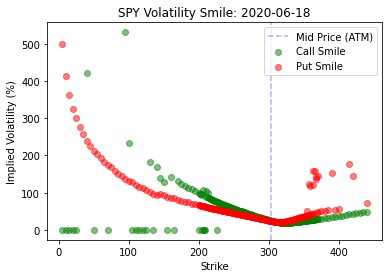

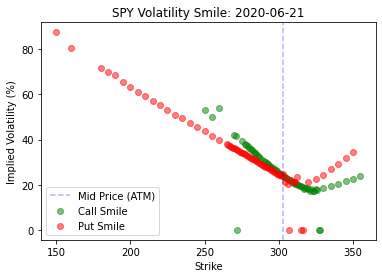

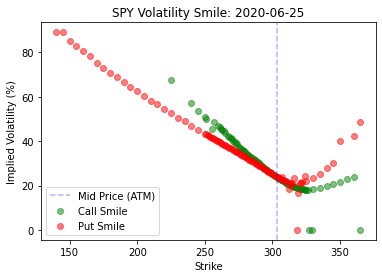

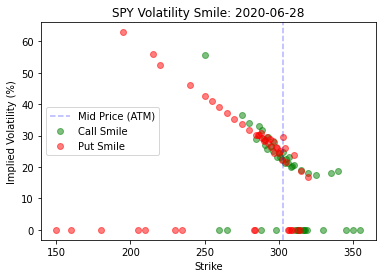

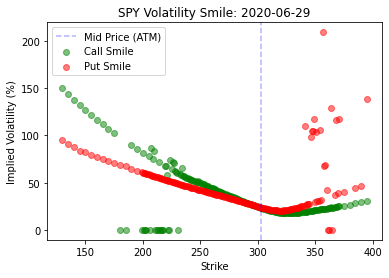

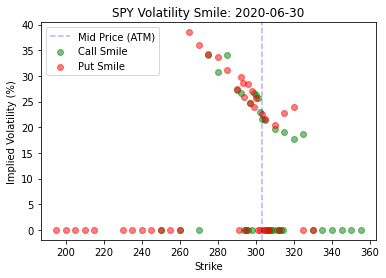

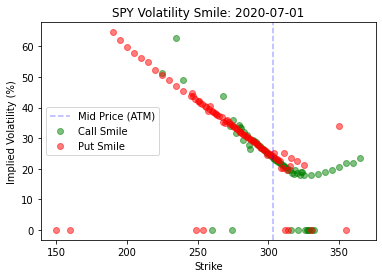

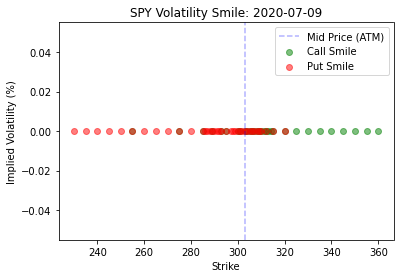

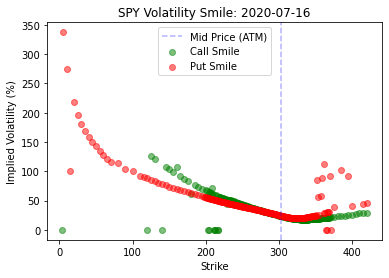

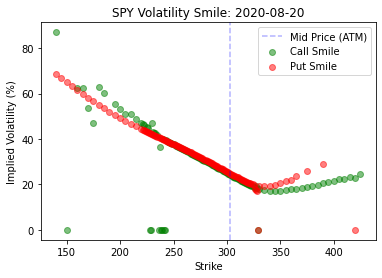

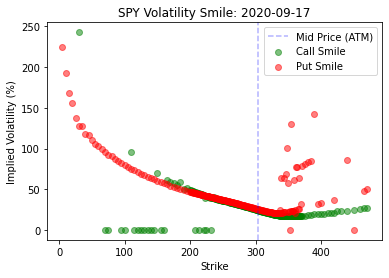

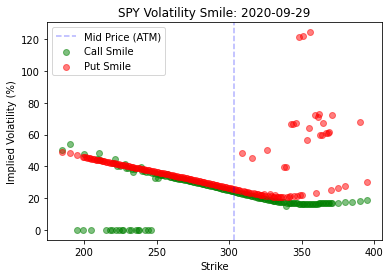

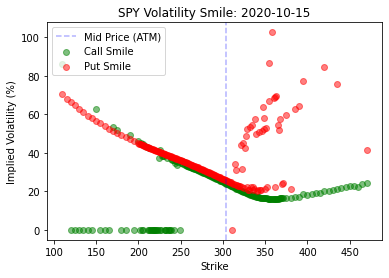

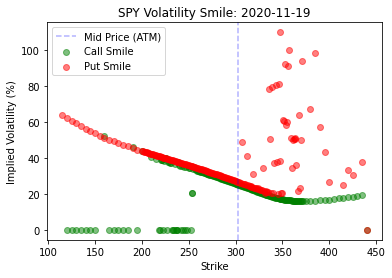

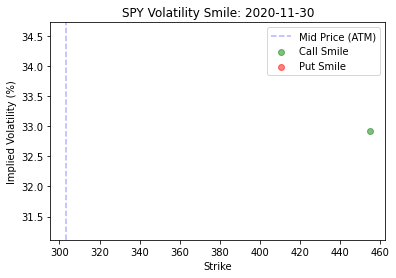

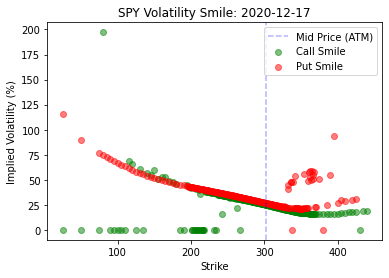

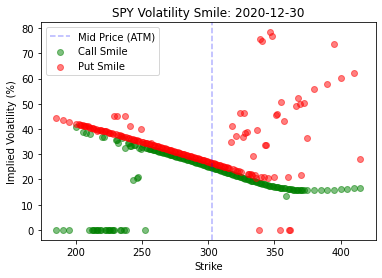

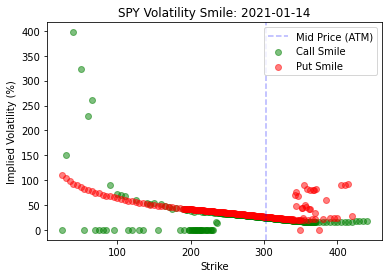

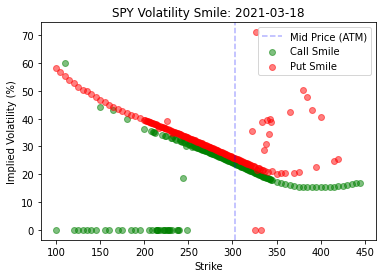

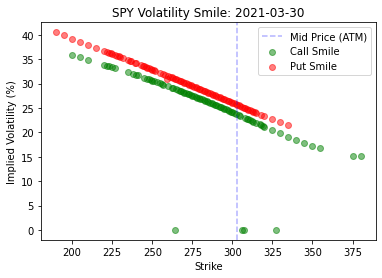

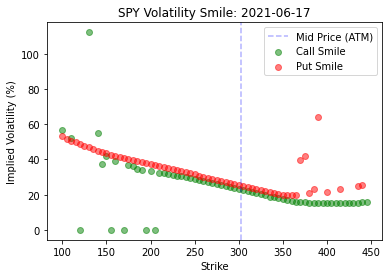

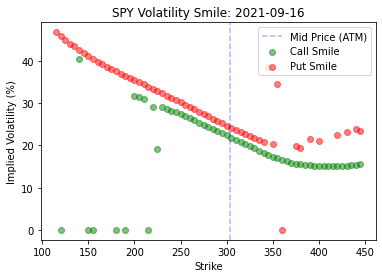

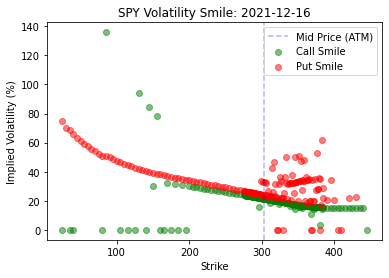

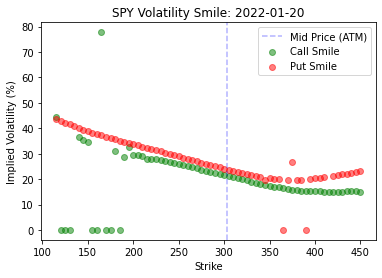

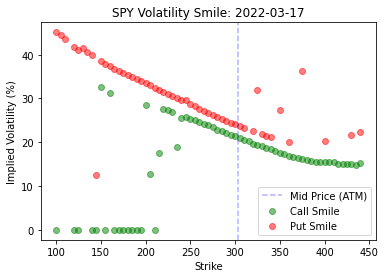

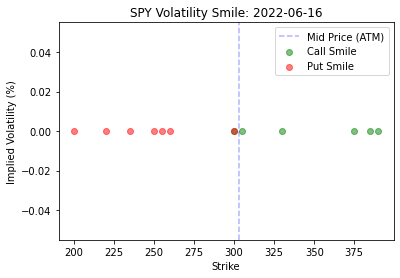

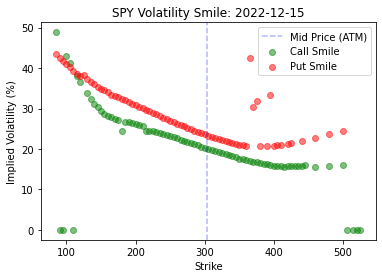

In [18]:
x.plot_vol_smile()

 32%|███▏      | 12/37 [00:02<00:04,  5.18it/s]

2020-06-23 option maturity failed to download


100%|██████████| 37/37 [00:08<00:00,  4.32it/s]


All option dates successfully downloaded:  False


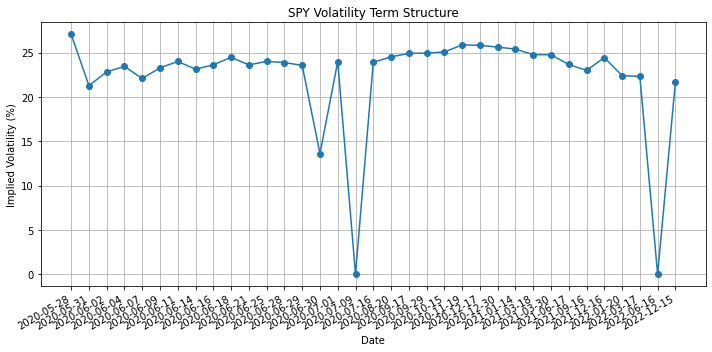

In [19]:
x.plot_vol_term_structure()